## 0. Raw data examination & preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
warnings.filterwarnings('ignore')

## 1. Regroup variables (Sean, R) -> directly load here

In [2]:
data = pd.read_csv('r_data_cleaned.csv',
           encoding = "ISO-8859-1")

In [4]:
data.columns.tolist()

['Unnamed: 0',
 'WorkerId',
 'Answer.age',
 'Answer.easy.concentration',
 'Answer.easy.conversation',
 'Answer.energetic',
 'Answer.game.normal.time',
 'Answer.game.yesterday.time',
 'Answer.leisure.ideal.time',
 'Answer.leisure.minimum.time',
 'Answer.leisure.normal.time',
 'Answer.leisure.yesterday.time',
 'Answer.sleep.ideal.time',
 'Answer.sleep.minimum.time',
 'Answer.sleep.normal.time',
 'Answer.sleep.yesterday.time',
 'Answer.sleepy',
 'Answer.socialize.ideal.time',
 'Answer.socialize.minimum.time',
 'Answer.socialize.normal.time',
 'Answer.socialmedia.normal.time',
 'Answer.socialmedia.yesterday.time',
 'Answer.tired',
 'Answer.work.ideal.time',
 'Answer.work.minimum.time',
 'Answer.work.normal.time',
 'Answer.work.yesterday.time',
 'Answer.yesterday.energy',
 'Answer.youtube.normal.time',
 'Answer.youtube.yesterday.time',
 'WorkerId.1',
 'Answer.location',
 'Answer.marital',
 'Answer.meal.minimum',
 'Answer.meal.normal',
 'Answer.meal.yesterday',
 'Answer.occupation',
 'Answer

In [5]:
data = data.drop(columns = ['WorkerId', 'Unnamed: 0','WorkerId.1','WorkerId.2',
                           'Answer.location.1',
 'Answer.marital.1',
 'Answer.meal.ideal',
 'Answer.meal.minimum.1',
 'Answer.meal.normal.1',
 'Answer.meal.yesterday.1',
 'Answer.occupation.1',
 'Answer.prefer.activity.1',
 'Answer.rise.time.normal.1',
 'Answer.rise.time.yesterday.1',
 'Answer.social.event.yesterday.1',
 'Answer.meal.time.normal.1',
 'Answer.meal.time.yesterday.1'])

## 2. Clean non-numeric values

In [7]:
l1 = data.columns.tolist()

In [8]:
#examine data type
for col in l1:
    print(col, "; type: ", data[col].dtype)

Answer.age ; type:  int64
Answer.easy.concentration ; type:  int64
Answer.easy.conversation ; type:  int64
Answer.energetic ; type:  int64
Answer.game.normal.time ; type:  float64
Answer.game.yesterday.time ; type:  float64
Answer.leisure.ideal.time ; type:  float64
Answer.leisure.minimum.time ; type:  float64
Answer.leisure.normal.time ; type:  float64
Answer.leisure.yesterday.time ; type:  float64
Answer.sleep.ideal.time ; type:  float64
Answer.sleep.minimum.time ; type:  float64
Answer.sleep.normal.time ; type:  float64
Answer.sleep.yesterday.time ; type:  float64
Answer.sleepy ; type:  int64
Answer.socialize.ideal.time ; type:  float64
Answer.socialize.minimum.time ; type:  float64
Answer.socialize.normal.time ; type:  float64
Answer.socialmedia.normal.time ; type:  float64
Answer.socialmedia.yesterday.time ; type:  float64
Answer.tired ; type:  int64
Answer.work.ideal.time ; type:  float64
Answer.work.minimum.time ; type:  float64
Answer.work.normal.time ; type:  float64
Answer.wo

In [9]:
obj_col_list = []
for column in l1:
    if re.match(r"Answer.+", column) and data[column].dtype == object\
    and column not in ['Answer.meal.time.normal', 'Answer.meal.time.yesterday']:
        obj_col_list.append(column)

In [10]:
#for object type columns, strip the string and only keep the last part
for index, row in data.iterrows():
    for col in obj_col_list:
        if isinstance(row[col], str):
            s = row[col].split('.')
            data.at[index, col] = s[-1]

In [11]:
data.columns[data.isnull().any()]

Index(['Answer.location', 'Answer.marital', 'Answer.meal.minimum',
       'Answer.meal.normal', 'Answer.meal.yesterday', 'Answer.occupation',
       'Answer.prefer.activity', 'Answer.rise.time.normal',
       'Answer.rise.time.yesterday', 'Answer.social.event.yesterday',
       'Answer.meal.time.normal', 'Answer.meal.time.yesterday',
       'Answer.bed.time.normal', 'Answer.ethnicity',
       'Answer.bed.time.yesterday', 'Answer.gender', 'Answer.income',
       'Answer.introvert'],
      dtype='object')

## 3. Feature engineering

### Add column: Calculate a "meal irregularity score":
1. For each row, compare L1 = 'Answer.meal.time.normal' with L2 = 'Answer.meal.time.yesterday'
2. If L1 is empty -> score = -1 (not applicable)
3. Find L = intersection(L1, L2)
4. Score = L1\L + L2\L

<span style=color:red>Problem/Improvement: The score isn't exactly calculating the number of meals that are different but rather calculating the difference in terms of characters in string.</span>

In [13]:
for index, row in data.iterrows():
    if pd.isna(row['Answer.meal.time.normal']):
        score = -1
    else:
        L1 = set(row['Answer.meal.time.normal'])
        if pd.isna(row['Answer.meal.time.yesterday']):
            score = len(L1)
        else:
            L2 = set(row['Answer.meal.time.yesterday'])   
            L = L1 & L2
            score = len(L1 - L) + len(L2 - L)
    data.at[index, 'Meal_Irregularity_Score'] = score

In [14]:
#drop the original two columns
data = data.drop(columns = ['Answer.meal.time.normal', 'Answer.meal.time.yesterday'])
data.head(5)

,Answer.age,Answer.easy.concentration,Answer.easy.conversation,Answer.energetic,Answer.game.normal.time,Answer.game.yesterday.time,Answer.leisure.ideal.time,Answer.leisure.minimum.time,Answer.leisure.normal.time,Answer.leisure.yesterday.time,...,Answer.rise.time.normal,Answer.rise.time.yesterday,Answer.social.event.yesterday,Answer.bed.time.normal,Answer.ethnicity,Answer.bed.time.yesterday,Answer.gender,Answer.income,Answer.introvert,Meal_Irregularity_Score
0,48,0,0,0,0.0,0.0,4.0,3.0,2.0,0.0,...,1,1,YN,2,White,3,Female,4,1,-1.0
1,58,7,9,1,8.0,9.0,5.0,3.0,3.0,7.0,...,2,2,YN,5,Asian,6,Male,4,1,-1.0
2,60,5,5,0,0.0,0.0,6.0,4.0,4.0,6.0,...,1,1,YN,4,White,5,Female,2,1,3.0
3,23,10,10,10,0.0,0.0,1.0,0.5,0.5,0.5,...,1,1,YP,3,White,3,Female,2,2,3.0
4,26,9,5,7,0.0,0.0,3.0,0.0,2.0,0.0,...,1,1,YP,4,Asian,4,Male,1,0,-1.0


In [15]:
data['Answer.gender']

0      Female
1        Male
2      Female
3      Female
4        Male
5      Female
6        Male
7      Female
8      Female
9      Female
10     Female
11     Female
12       Male
13       Male
14     Female
15     Female
16       Male
17     Female
18     Female
19       Male
20       Male
21     Female
22     Female
23     Female
24       Male
25     Female
26       Male
27       Male
28       Male
29     Female
        ...  
467    Female
468      Male
469    Female
470      Male
471    Female
472    Female
473      Male
474    Female
475    Female
476    Female
477      Male
478    Female
479      Male
480    Female
481      Male
482    Female
483    Female
484    Female
485      Male
486    Female
487    Female
488      Male
489    Female
490      Male
491      Male
492    Female
493    Female
494       NaN
495      Male
496    Female
Name: Answer.gender, Length: 497, dtype: object

### Fill NA

In [16]:
data['Answer.gender'].fillna(value='Decline', inplace=True)
data['Answer.ethnicity'].fillna(value='Decline', inplace=True)
data['Answer.occupation'].fillna(value='Decline', inplace=True)

#the rest fill with zero
data.fillna(value=0,inplace=True)

### One hot encoding

In [17]:
#one hot encoding for object type columns
obj_col_list = []
for column in data.columns.tolist():
    if re.match(r"Answer.+", column) and data[column].dtype == object:
        obj_col_list.append(column)
obj_col_list

['Answer.location',
 'Answer.marital',
 'Answer.meal.minimum',
 'Answer.meal.normal',
 'Answer.meal.yesterday',
 'Answer.occupation',
 'Answer.prefer.activity',
 'Answer.rise.time.normal',
 'Answer.rise.time.yesterday',
 'Answer.social.event.yesterday',
 'Answer.bed.time.normal',
 'Answer.ethnicity',
 'Answer.bed.time.yesterday',
 'Answer.gender',
 'Answer.income',
 'Answer.introvert']

In [18]:
enc_list = ['Answer.ethnicity', 'Answer.marital','Answer.location','Answer.occupation',\
           'Answer.gender', 'Answer.social.event.yesterday','Answer.marital',\
           'Answer.prefer.activity','Answer.social.event.yesterday']
for col in enc_list:
    data[col] = pd.factorize(data[col], sort=True)[0]

In [19]:
for col in obj_col_list:
    data[col]  = pd.Categorical(data[col])

In [20]:
data.select_dtypes("category").columns.tolist()

['Answer.location',
 'Answer.marital',
 'Answer.meal.minimum',
 'Answer.meal.normal',
 'Answer.meal.yesterday',
 'Answer.occupation',
 'Answer.prefer.activity',
 'Answer.rise.time.normal',
 'Answer.rise.time.yesterday',
 'Answer.social.event.yesterday',
 'Answer.bed.time.normal',
 'Answer.ethnicity',
 'Answer.bed.time.yesterday',
 'Answer.gender',
 'Answer.income',
 'Answer.introvert']

In [21]:
data.dtypes

Answer.age                              int64
Answer.easy.concentration               int64
Answer.easy.conversation                int64
Answer.energetic                        int64
Answer.game.normal.time               float64
Answer.game.yesterday.time            float64
Answer.leisure.ideal.time             float64
Answer.leisure.minimum.time           float64
Answer.leisure.normal.time            float64
Answer.leisure.yesterday.time         float64
Answer.sleep.ideal.time               float64
Answer.sleep.minimum.time             float64
Answer.sleep.normal.time              float64
Answer.sleep.yesterday.time           float64
Answer.sleepy                           int64
Answer.socialize.ideal.time           float64
Answer.socialize.minimum.time         float64
Answer.socialize.normal.time          float64
Answer.socialmedia.normal.time        float64
Answer.socialmedia.yesterday.time     float64
Answer.tired                            int64
Answer.work.ideal.time            

### Add column: How you feel today by taking the mean of 5 measurements

In [22]:
l = ['Answer.easy.concentration', 'Answer.easy.conversation',\
        'Answer.energetic','Answer.tired','Answer.sleepy']      

for index, row in data.iterrows():
    score = 0
    for col in l:
        score += row[col]
    data.at[index, 'Energy_today'] = score/5

In [23]:
data['Energy_today'].describe()

count    497.000000
mean       4.498189
std        1.382384
min        0.000000
25%        3.600000
50%        4.600000
75%        5.400000
max       10.000000
Name: Energy_today, dtype: float64

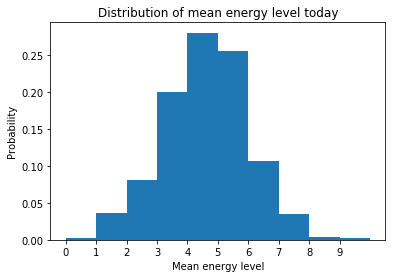

In [24]:
plt.hist(data['Energy_today'], normed=True, bins=10)
plt.xticks(np.arange(10))
plt.xlabel("Mean energy level")
plt.ylabel("Probability")
plt.title("Distribution of mean energy level today")
plt.show()

## 5. Output to csv

In [25]:
file_name="data_final.csv"
data.to_csv(file_name, index=False)

In [26]:
data.describe()

,Answer.age,Answer.easy.concentration,Answer.easy.conversation,Answer.energetic,Answer.game.normal.time,Answer.game.yesterday.time,Answer.leisure.ideal.time,Answer.leisure.minimum.time,Answer.leisure.normal.time,Answer.leisure.yesterday.time,...,Answer.tired,Answer.work.ideal.time,Answer.work.minimum.time,Answer.work.normal.time,Answer.work.yesterday.time,Answer.yesterday.energy,Answer.youtube.normal.time,Answer.youtube.yesterday.time,Meal_Irregularity_Score,Energy_today
count,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,...,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000
mean,38.907445,5.074447,4.738431,4.289738,1.704795,1.469718,5.554728,3.402918,3.148994,3.143897,...,4.219316,6.924748,7.816365,7.736821,7.347082,4.770624,2.590845,2.226761,3.130785,4.498189
std,12.227163,3.049407,3.224777,3.068531,3.140303,3.130311,4.406226,3.353334,3.358878,3.411934,...,3.106021,3.248912,3.191562,3.695645,3.703235,2.882739,3.226925,2.987255,4.194971,1.382384
min,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,29.000000,2.000000,2.000000,1.000000,0.000000,0.000000,3.000000,1.500000,1.016667,1.000000,...,1.000000,5.000000,7.000000,5.533333,5.000000,2.000000,1.000000,0.500000,-1.000000,3.600000
50%,36.000000,5.000000,5.000000,4.000000,0.500000,0.000000,4.000000,2.066667,2.000000,2.000000,...,4.000000,7.000000,8.000000,8.000000,8.000000,5.000000,2.000000,1.066667,3.000000,4.600000
75%,47.000000,8.000000,8.000000,7.000000,2.000000,1.066667,6.233333,4.000000,4.000000,4.000000,...,7.000000,8.016667,9.000000,10.000000,9.016667,7.000000,3.000000,3.000000,3.000000,5.400000
max,78.000000,10.000000,10.000000,10.000000,24.000000,21.883333,24.133333,24.000000,24.983333,22.666667,...,10.000000,25.000000,23.000000,23.000000,23.833333,10.000000,23.916667,23.900000,20.000000,10.000000


In [27]:
# list_cat = []
# for i in range(28, 58):
#     list_cat.append(i)
# list_cat

28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,56,57

(28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 56,
 57)

In [ ]:
data.to_numpy

In [ ]:
from kmodes.kprototypes import KPrototypes
data[:, 0] = data[:, 0].astype(float)
kp=KPrototypes(n_clusters=2, init='Huang')
cluster=kp.fit_predict(data, categorical=[28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,56,57])
                            
                                       